Initialize the enviroment and import the packages

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Read CSV data file

In [2]:
#data <- read_csv("data/heart_attack.csv")
url = "https://raw.githubusercontent.com/l-glucose/dsci100/main/data/heart_attack.csv"
data <- read_csv(url)
data
sum(is.na(data))

Rows: 1319 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): class
dbl (8): age, gender, impluse, pressurehight, pressurelow, glucose, kcm, tro...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
64,1,66,160,83,160,1.80,0.012,negative
21,1,94,98,46,296,6.75,1.060,positive
55,1,64,160,77,270,1.99,0.003,negative
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,85,168,104,96,1.24,4.250,positive
54,1,58,117,68,443,5.80,0.359,positive
51,1,94,157,79,134,50.89,1.770,positive


[1] 0

In [4]:
data <- data |>
    mutate(class = as_factor(class))
data <- data |>
    filter(impluse <= 200)
data <- data |>
    mutate(pressure_diff = pressurehight - pressurelow)
data_split <- initial_split(data, prop = 0.75, strata = class) 
data_training <- training(data_split)
data_testing <- testing(data_split)

data_training |> map.df()


age,gender,impluse,pressurehight,pressurelow,glucose,kcm,troponin,class,pressure_diff
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
64,1,66,160,83,160,1.80,0.012,negative,77
55,1,64,112,65,300,1.08,0.003,negative,47
58,0,61,112,58,87,1.83,0.004,negative,54
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,85,168,104,96,1.24,4.250,positive,64
54,1,58,117,68,443,5.80,0.359,positive,49
51,1,94,157,79,134,50.89,1.770,positive,78


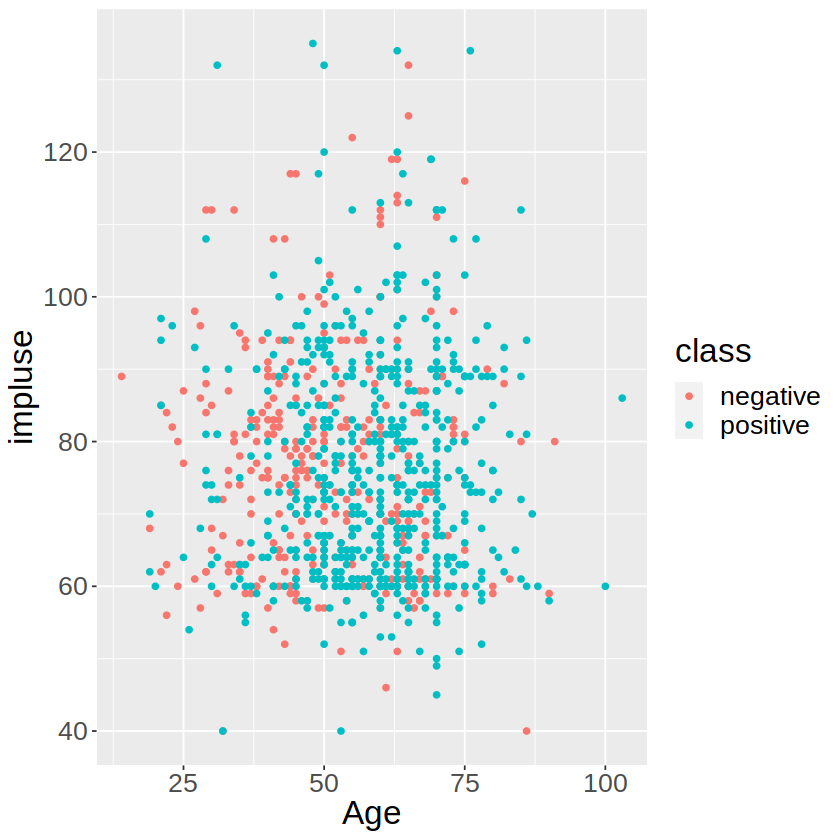

In [5]:
plot <- data_training |> ggplot(aes(x = age, y = impluse, color = class)) + 
    geom_point() +
    xlab("Age") + 
    ylab("impluse") +
    theme(text = element_text(size=20))
plot

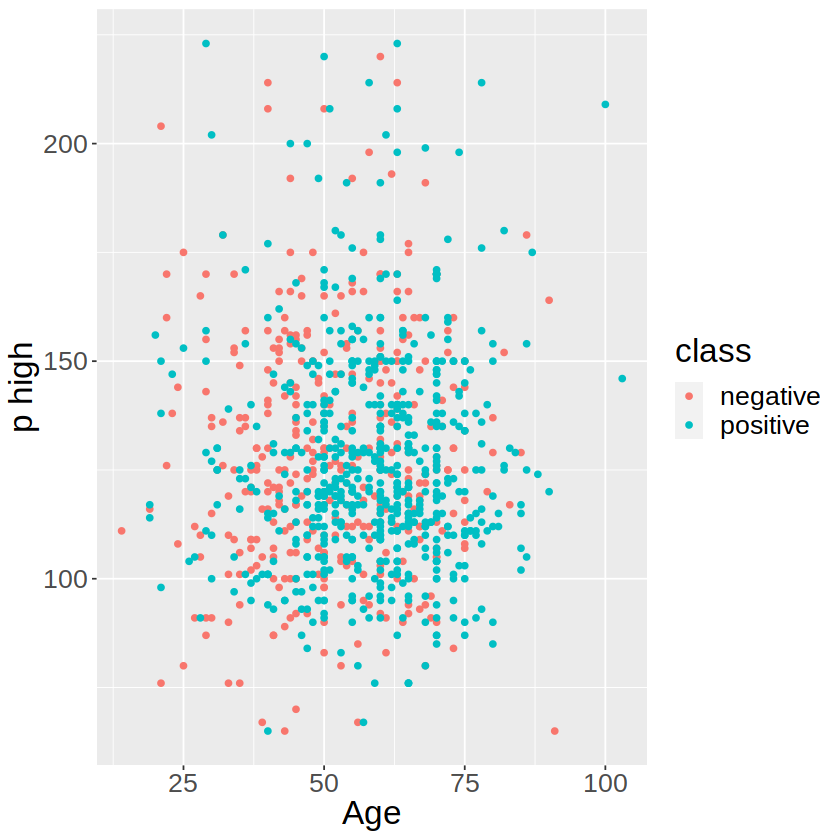

In [6]:
# sample_50 <- sample_n(data, 50)
plot_diff <- data_training |> ggplot(aes(x = age, y = pressurehight, color = class)) + 
    geom_point() +
    xlab("Age") + 
    ylab("p high") +
    theme(text = element_text(size=20))
plot_diff

In [7]:
data_age <- data_training |>
    group_by(age, class) |>
    summarize(kcm = mean(kcm, na.rm = TRUE))
data_age

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


age,class,kcm
<dbl>,<fct>,<dbl>
14,negative,2.620
19,negative,0.606
19,positive,168.120
⋮,⋮,⋮
91,negative,5.37
100,positive,5.66
103,positive,69.32


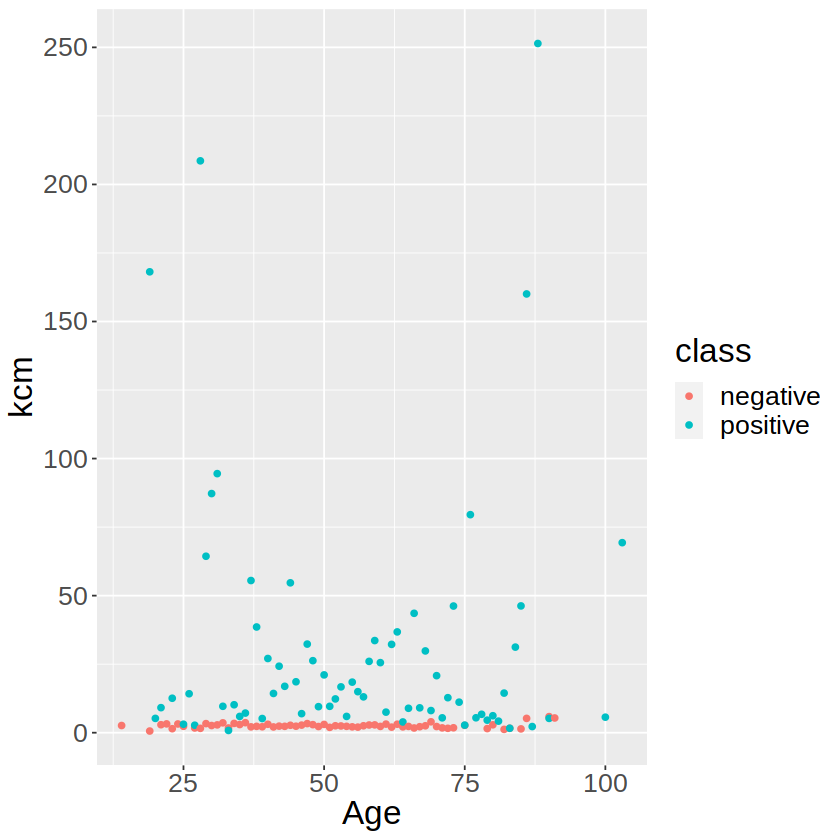

In [8]:
average_plot <- data_age |> ggplot(aes(x = age, y = kcm, color = class)) + 
    geom_point() +
    xlab("Age") + 
    ylab("kcm") +
    theme(text = element_text(size=20))
average_plot

`summarise()` has grouped output by 'kcm'. You can override using the `.groups`
argument.


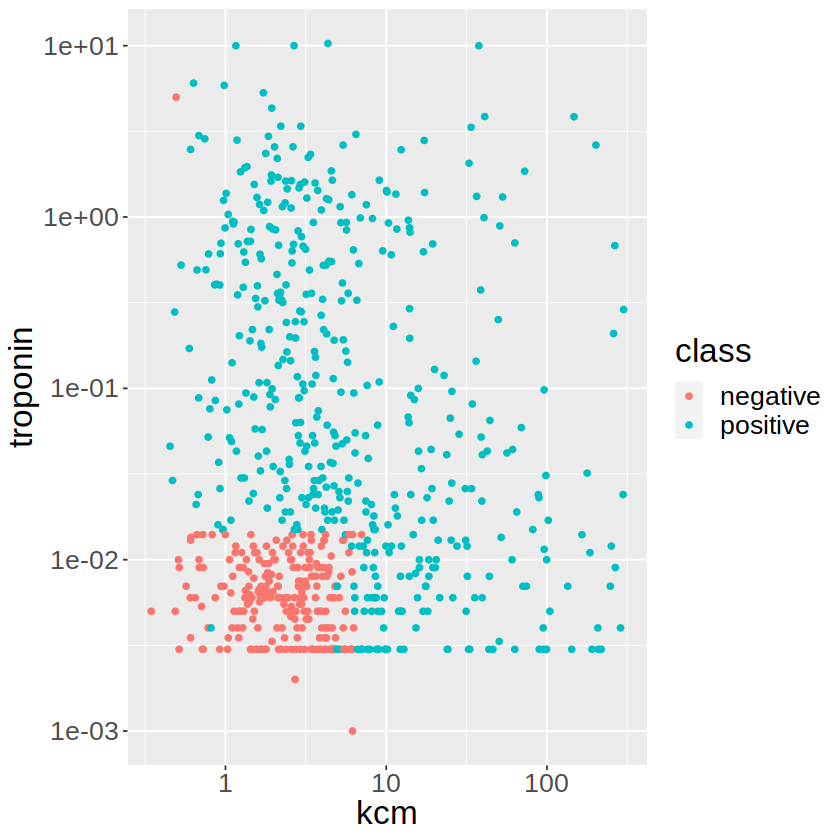

In [9]:
data_kcm <- data_training |>
    group_by(kcm, class) |>
    summarize(troponin = mean(troponin, na.rm = TRUE))

plot2 <- data_kcm |> ggplot(aes(x = kcm, y = troponin, color = class)) + 
    geom_point() +
    xlab("kcm") + 
    ylab("troponin") +
    scale_x_continuous(trans = 'log10') + 
    scale_y_continuous(trans = 'log10') + 
    theme(text = element_text(size=20))
plot2

In [10]:
create_age_group <- function(age) {
  if (age <= 25) {
    return("15-25")
  } else if (age <= 50) {
    return("26-50")
  } else if (age <= 75) {
    return("51-75")
  } else {
    return("76-90")
  }
}

summarized_data <- data_training |>
  mutate(age_group = sapply(age, create_age_group)) |>
  group_by(age_group, class) |>
  summarise(across(where(is.numeric), mean, .names = "mean_{.col}"), .groups = "drop")

summarized_data

age_group,class,mean_age,mean_gender,mean_impluse,mean_pressurehight,mean_pressurelow,mean_glucose,mean_kcm,mean_troponin,mean_pressure_diff
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15-25,negative,21.83333,0.6666667,74.41667,134.000,73.2500,141.1667,2.595500,0.004416667,60.75000
15-25,positive,21.12500,0.7500000,78.50000,134.125,75.5000,159.6250,48.065000,0.454500000,58.62500
26-50,negative,41.52299,0.6379310,76.03448,126.569,71.7069,146.9080,2.670736,0.005195402,54.86207
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
51-75,positive,62.53181,0.7048346,75.20102,126.7913,71.85751,148.0229,20.149832,0.56369975,54.93384
76-90,negative,84.00000,0.4444444,68.55556,132.4444,72.66667,146.4444,3.104444,0.01055556,59.77778
76-90,positive,81.38298,0.5106383,77.40426,128.0851,71.87234,145.5745,32.932234,0.22644681,56.21277
